# Regressão logística Multinomial
## Analisando a eficácia das vacinas Covid 19 entre diferentes faixas etárias utilizando o modelo de regressão logística multinomial

### Regressão Logística:

A regressão logística é um algoritmo de classificação binária usado quando a variável dependente é categórica e possui duas classes. Ele modela a probabilidade de uma instância pertencer a uma classe específica.

Na regressão logística binária, a saída do modelo é transformada usando a função logística (função sigmóide), que garante que os valores previstos fiquem entre 0 e 1. O limite de decisão é definido em 0,5 e as instâncias são classificadas com base em se a probabilidade prevista é acima ou abaixo deste limite.

### Regressão Logística Multinomial:

A regressão logística multinomial estende a regressão logística binária para lidar com várias classes. Em vez de prever um resultado binário, prevê a probabilidade de uma instância pertencer a cada classe. A função softmax é usada para transformar a saída bruta do modelo em uma distribuição de probabilidade em várias classes.

Aqui estão os principais componentes da regressão logística multinomial:

1. **Saída do modelo:**
    - Para cada classe, o modelo produz um conjunto separado de coeficientes.
    - A função softmax converte as pontuações brutas (logits) em probabilidades, garantindo que a soma das probabilidades seja 1 em todas as classes.

2. **Regra de decisão:**
    - A classe com maior probabilidade é escolhida como a classe prevista para uma determinada instância.

3. **Parâmetros:**
    - O modelo é treinado para aprender um conjunto de parâmetros (coeficientes) que maximizam a probabilidade dos dados observados.

4. **Função de perda:**
    - A função de perda de entropia cruzada é comumente usada para treinar modelos de regressão logística multinomial. Ele mede a diferença entre as probabilidades previstas e os rótulos reais das classes.


### Exemplos práticos:

A regressão logística multinomial é adequada para cenários onde há mais de duas classes e as classes são mutuamente exclusivas. Exemplos incluem:
- Prever o tipo de fruta (por exemplo, maçã, laranja, banana) com base em determinadas características.
- Prever o resultado de um diagnóstico médico (por exemplo, saudável, leve, grave).

```python
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
```

No geral, a regressão logística multinomial é um algoritmo fundamental para problemas de classificação multiclasse e serve como um alicerce para modelos mais complexos em aprendizado de máquina.

Carregando as bibliotecas

In [1]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import warnings

# Suprimir warnings específicos
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
dados = pd.read_excel('dados_covid19_vacinas.xlsx')

# Entendimento da Base de dados


 **Date:**
Data em que as observações foram registradas. Intervalo de registros compreendido entre: 2021-09-05 e 2021-12-31.

**Idade_agrupamento:**
Variavel categórica que agrupa a idade dos individuos infectados com COVID

| Age Group | Category |
|-----------|----------|
| 1         | 0-19     |
| 2         | 19-29    |
| 3         | 29-39    |
| 4         | 39-49    |
| 5         | 49-59    |
| 6         | 59-69    |
| 7         | 69-79    |
| 8         | 79-80+   |

 **nao_vacinados:** Nº de pessoas que foram infectadas com o COVID-19 e  não receberam nenhuma dose de vacina

**vacinados_parcialmente:** Nº de pessoas que foram infectadas com o COVID-19 e receberam pelo menos uma dose da vacina, mas nao estavam totalmente vacinados.

**totalmente_vacinados:** Nº de pessoas que foram infectadas com o COVID-19 e estavam totalmente vacinados.

Em resumo, o conjunto de dados captura informações sobre casos de COVID-19 com base em faixas etárias e estado de vacinação em uma data específica. As variáveis incluem a data de observação, a categorização da faixa etária e o número de casos de indivíduos não vacinados, parcialmente vacinados e totalmente vacinados dentro de cada faixa etária.

Visualizando os dados carregados

In [3]:
dados.head()

,Date,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
0,2021-09-05,1,98,7,0
1,2021-09-05,2,63,12,9
2,2021-09-05,3,50,4,11
3,2021-09-05,4,28,3,9
4,2021-09-05,5,29,0,9


Validação da base de dados

In [4]:
dados.columns

Index(['Date', 'idade_agrupamento', 'nao_vacinados', 'vacinados_parcialmente',
       'totalmente_vacinados'],
      dtype='object')

In [5]:
dados.shape

(936, 5)

In [6]:
dados.describe()

,Date,idade_agrupamento
count,936,936.000000
mean,2021-11-02 21:20:00,4.500000
min,2021-09-05 00:00:00,1.000000
25%,2021-10-05 00:00:00,2.750000
50%,2021-11-03 00:00:00,4.500000
75%,2021-12-02 00:00:00,6.250000
max,2021-12-31 00:00:00,8.000000
std,NaN,2.292513


In [7]:
dados.dtypes

Date                      datetime64[ns]
idade_agrupamento                  int64
nao_vacinados                     object
vacinados_parcialmente            object
totalmente_vacinados              object
dtype: object

**Tratamento de Dados**

In [8]:
relevant_columns = ['nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']

Converter as colunas em numérico

In [9]:
dados[relevant_columns] = dados[relevant_columns].apply(pd.to_numeric, errors='coerce')

Preencher os dados ausentes com a média

In [10]:
dados[relevant_columns] = dados[relevant_columns].fillna(dados[relevant_columns].mean())

Verificar a quantidade de linhas na variável idade_agrupamento

In [11]:
print("Quantidade de linhas na variável idade_agrupamento:", dados['idade_agrupamento'].shape[0])

Quantidade de linhas na variável idade_agrupamento: 936


Preencher os dados ausentes na variável idade_agrupamento com o valor mais frequente

In [12]:
idade_agrupamento_mode = dados['idade_agrupamento'].mode()[0]
dados['idade_agrupamento'].fillna(idade_agrupamento_mode, inplace=True)

Verificar o número de linhas da variável de resposta e da matriz de variáveis explicativas

In [13]:
y = dados['idade_agrupamento']
X = dados[['nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']]
print("Número de linhas da variável de resposta:", y.shape[0])
print("Número de linhas da matriz de variáveis explicativas:", X.shape[0])

Número de linhas da variável de resposta: 936
Número de linhas da matriz de variáveis explicativas: 936


In [14]:
dados.describe()

,Date,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
count,936,936.000000,936.000000,936.000000,936.000000
mean,2021-11-02 21:20:00,4.500000,23.004301,1.149451,6.425668
min,2021-09-05 00:00:00,1.000000,0.000000,0.000000,0.000000
25%,2021-10-05 00:00:00,2.750000,3.750000,0.000000,2.000000
50%,2021-11-03 00:00:00,4.500000,10.000000,0.000000,5.000000
75%,2021-12-02 00:00:00,6.250000,28.000000,2.000000,8.000000
max,2021-12-31 00:00:00,8.000000,240.000000,13.000000,94.000000
std,NaN,2.292513,33.041604,1.789953,6.860924


In [15]:
dados

,Date,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
0,2021-09-05,1,98.0,7.0,0.0
1,2021-09-05,2,63.0,12.0,9.0
2,2021-09-05,3,50.0,4.0,11.0
3,2021-09-05,4,28.0,3.0,9.0
4,2021-09-05,5,29.0,0.0,9.0
...,...,...,...,...,...
931,2021-12-31,4,70.0,0.0,42.0
932,2021-12-31,5,51.0,0.0,24.0
933,2021-12-31,6,35.0,0.0,9.0
934,2021-12-31,7,6.0,0.0,7.0


In [16]:
variaveis = dados[['idade_agrupamento', 'nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']]

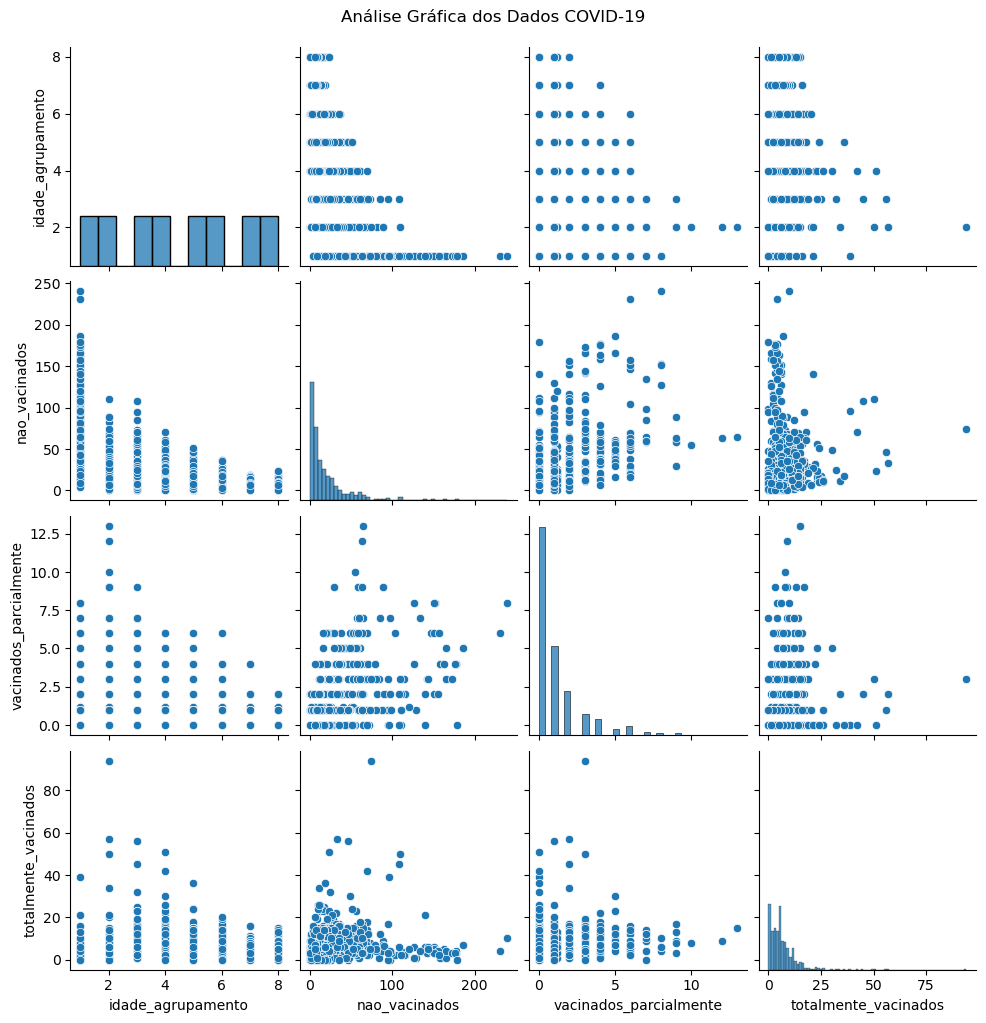

In [17]:
# Análise gráfica - Pairplot
import seaborn as sns
sns.pairplot(variaveis)
plt.suptitle("Análise Gráfica dos Dados COVID-19", y=1.02)
plt.show()

In [18]:
variaveis.corr()

,idade_agrupamento,nao_vacinados,vacinados_parcialmente,totalmente_vacinados
idade_agrupamento,1.000000,-0.537975,-0.377692,-0.149968
nao_vacinados,-0.537975,1.000000,0.564211,0.172234
vacinados_parcialmente,-0.377692,0.564211,1.000000,0.209882
totalmente_vacinados,-0.149968,0.172234,0.209882,1.000000


Criando o Modelo 

In [19]:
y = dados['idade_agrupamento']
X = dados[['nao_vacinados', 'vacinados_parcialmente', 'totalmente_vacinados']]

Dividir os dados em conjuntos de treinamento e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Verificar o tamanho de cada conjunto de dados

In [21]:
print("Tamanho do conjunto de treinamento (X_train):", X_train.shape)
print("Tamanho do conjunto de teste (X_test):", X_test.shape)
print("Tamanho do conjunto de treinamento (y_train):", y_train.shape)
print("Tamanho do conjunto de teste (y_test):", y_test.shape)

Tamanho do conjunto de treinamento (X_train): (748, 3)
Tamanho do conjunto de teste (X_test): (188, 3)
Tamanho do conjunto de treinamento (y_train): (748,)
Tamanho do conjunto de teste (y_test): (188,)


In [22]:
# Ajustar o modelo de regressão logística multinomial usando statsmodels
model = sm.MNLogit(y_train, sm.add_constant(X_train))
results = model.fit()

# Resumo do modelo
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.679980
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:      idade_agrupamento   No. Observations:                  748
Model:                        MNLogit   Df Residuals:                      720
Method:                           MLE   Df Model:                           21
Date:                Sat, 29 Jun 2024   Pseudo R-squ.:                  0.1916
Time:                        20:29:35   Log-Likelihood:                -1256.6
converged:                       True   LL-Null:                       -1554.4
Covariance Type:            nonrobust   LLR p-value:                1.396e-112
   idade_agrupamento=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.4551      0.356      1.280      0.201      -0.242      

### Verificando os pressupostos

In [23]:
# Obter probabilidades previstas
probabilidades_previstas = results.predict()

### Deviance Residuals

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   A deviance total é comparada com uma distribuição qui-quadrado com $n - p$ graus de liberdade, onde $n$ é o número de observações e $p$ é o número de parâmetros no modelo.

-   **Aceitação de** $H_0$: Se o valor $p$ calculado a partir da deviance é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.


In [24]:
# Resíduos: calcular resíduos deviance manualmente
def residuos_deviance(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1-1e-10)  # Evitar log(0)
    deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
    deviance_residuals[np.isnan(deviance_residuals)] = 0  # Substituir NaNs por 0
    return deviance_residuals

In [25]:
# One-hot encoding para y_train
y_train_onehot = pd.get_dummies(y_train).values

In [26]:
# Calcular resíduos deviance
residuos_deviance_val = residuos_deviance(y_train_onehot, probabilidades_previstas)

C:\Users\anail\AppData\Local\Temp\ipykernel_24380\396778356.py:4: RuntimeWarning: divide by zero encountered in log
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))
C:\Users\anail\AppData\Local\Temp\ipykernel_24380\396778356.py:4: RuntimeWarning: invalid value encountered in multiply
  deviance_residuals = 2 * (y_true * np.log(y_true / y_pred))


In [27]:
# Deviance total e p-valor
deviance_total = np.sum(residuos_deviance_val)
deviance_p_value = chi2.sf(deviance_total, results.df_resid)
print(f"Deviance: {deviance_total}, p-value: {deviance_p_value}")

Deviance: 2513.25013721276, p-value: 9.36509057757037e-197


In [28]:
# Pearson Chi-Square Test
def residuos_pearson(y_true, y_pred):
    return (y_true - y_pred) / np.sqrt(y_pred * (1 - y_pred))

In [29]:
residuos_pearson_val = residuos_pearson(y_train_onehot, probabilidades_previstas)
pearson_chi2 = np.sum(residuos_pearson_val ** 2)
pearson_p_value = chi2.sf(pearson_chi2, results.df_resid)
print(f"Pearson Chi-Square Test: Chi2={pearson_chi2}, p-value={pearson_p_value}")

Pearson Chi-Square Test: Chi2=6657.262375309852, p-value=0.0


### Teste de Hosmer-Lemeshow

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados (não há diferença significativa entre as frequências observadas e esperadas).

-   $H_a$: O modelo não ajusta bem os dados (há diferença significativa entre as frequências observadas e esperadas).

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste de Hosmer-Lemeshow, que segue uma distribuição qui-quadrado com $g - 2$ graus de liberdade, onde $g$ é o número de grupos.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que o nível de significância $\alpha$ (geralmente 0.05), aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.

In [30]:
# Teste de Hosmer-Lemeshow
def hosmer_lemeshow_test(y_true, y_pred, g=10):
    data = pd.DataFrame({'observed': np.argmax(y_true, axis=1), 'predicted': np.max(y_pred, axis=1)})
    data['group'] = pd.qcut(data['predicted'], g, duplicates='drop')
    grouped = data.groupby('group')
    observed = grouped['observed'].sum()
    expected = grouped['predicted'].sum()
    hl_stat = ((observed - expected) ** 2 / (expected * (1 - expected / grouped.size()))).sum()
    hl_p_value = chi2.sf(hl_stat, g - 2)
    return hl_stat, hl_p_value

In [31]:
hl_stat, hl_p_value = hosmer_lemeshow_test(y_train_onehot, probabilidades_previstas)
print(f"Hosmer-Lemeshow Test: Stat={hl_stat}, p-value={hl_p_value}")

Hosmer-Lemeshow Test: Stat=49180.320114810005, p-value=0.0


## Testes de adequação do modelo

### 1. Pearson Chi-Square Test

**Hipótese Testada:**

-   $H_0$: O modelo ajusta bem os dados.

-   $H_a$: O modelo não ajusta bem os dados.

**Condição de Aceitação/Rejeição:**

-   Calcula-se a estatística do teste qui-quadrado de Pearson, que segue uma distribuição qui-quadrado com $n - p$ graus de liberdade.

-   **Aceitação de** $H_0$: Se o valor $p$ é maior que $\alpha$, aceitamos $H_0$ e concluímos que o modelo ajusta bem os dados.

-   **Rejeição de** $H_0$: Se o valor $p$ é menor que $\alpha$, rejeitamos $H_0$ e concluímos que o modelo não ajusta bem os dados.


In [32]:
import scipy.stats as stats

# Calcular o valor p para o teste de Razão de Verossimilhança (LR)
lrt_test_statistic = results.llr  # Obtém o valor do teste de Likelihood Ratio
lrt_df = results.df_model  # Obtém os graus de liberdade do modelo
lrt_p_value = 1 - stats.chi2.cdf(lrt_test_statistic, lrt_df)

print("\nTeste de Razão de Verossimilhança (LR) para os Resíduos:")
print(f"Estatística de teste: {lrt_test_statistic}")
print(f"Graus de liberdade: {lrt_df}")
print(f"Valor p: {lrt_p_value}")


Teste de Razão de Verossimilhança (LR) para os Resíduos:
Estatística de teste: 595.5241271260438
Graus de liberdade: 21.0
Valor p: 0.0


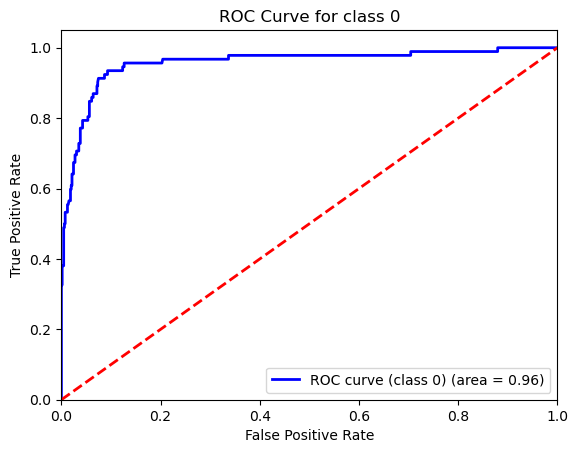

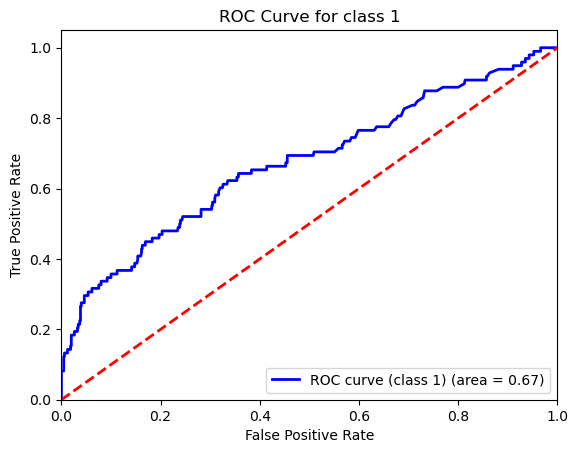

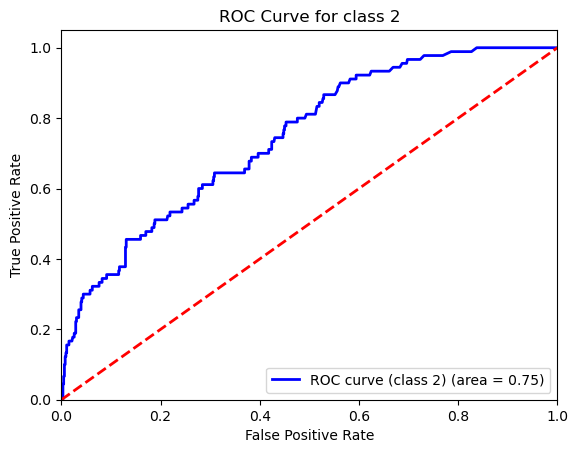

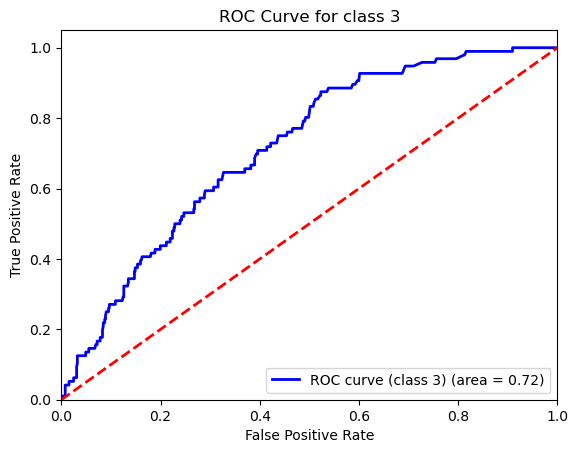

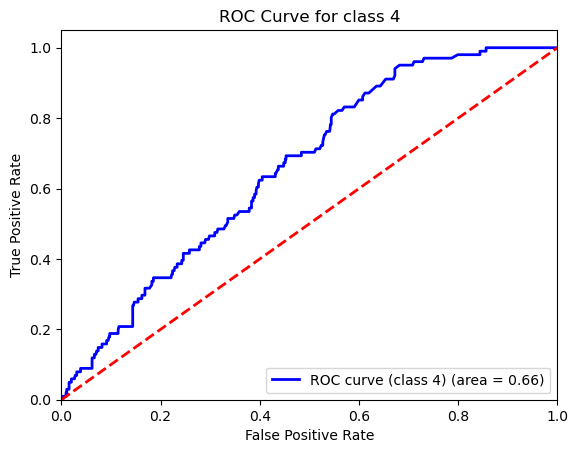

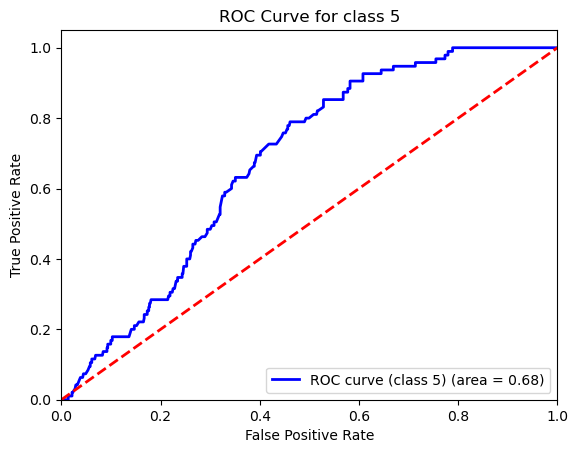

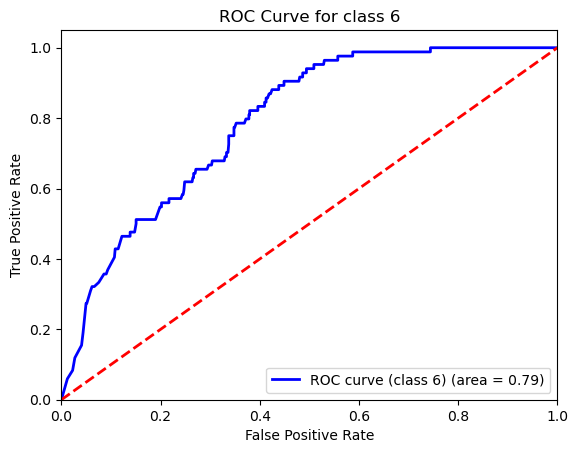

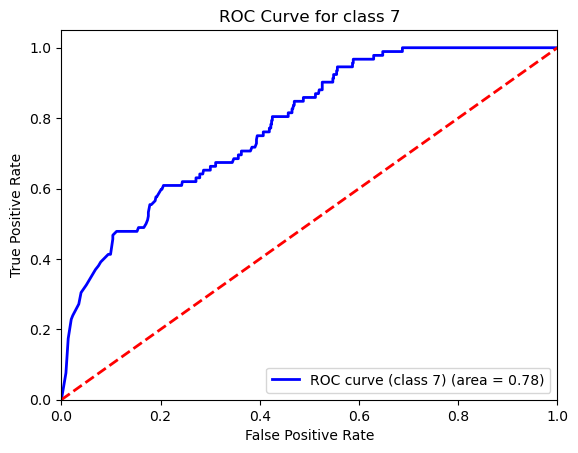

In [33]:
# Curva ROC para cada classe
for i in range(y_train_onehot.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_onehot[:, i], probabilidades_previstas[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (class {i}) (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for class {i}')
    plt.legend(loc="lower right")
    plt.show()


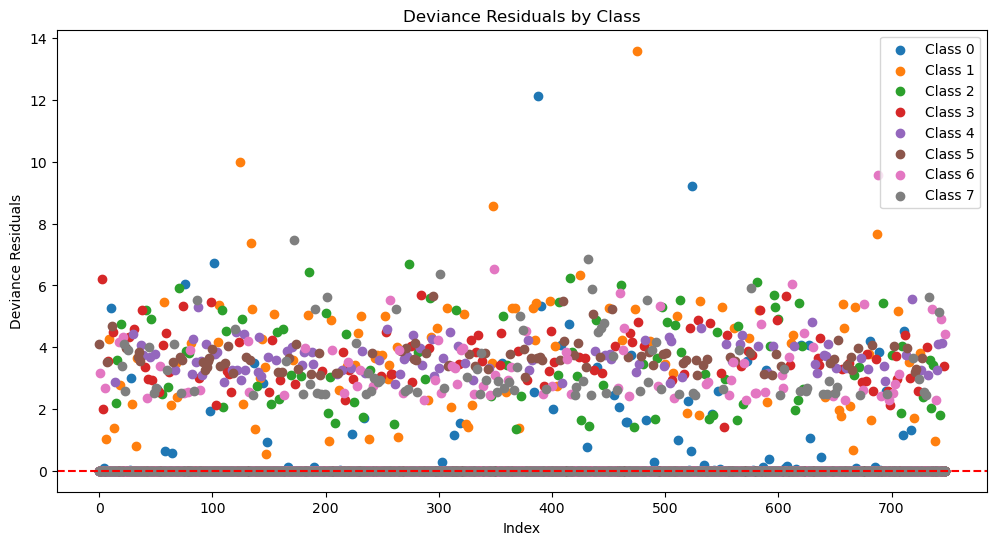

In [34]:
# Plotar resíduos deviance
plt.figure(figsize=(12, 6))
for i in range(residuos_deviance_val.shape[1]):
    plt.scatter(range(len(residuos_deviance_val)), residuos_deviance_val[:, i], label=f'Class {i}')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Deviance Residuals')
plt.title('Deviance Residuals by Class')
plt.legend()
plt.show()

In [35]:
results.params

,0,1,2,3,4,5,6
const,0.455112,-0.381851,0.202752,0.775735,1.103554,2.057098,1.983120
nao_vacinados,-0.094998,-0.093034,-0.111400,-0.115569,-0.131240,-0.171120,-0.174153
vacinados_parcialmente,1.198660,1.075576,0.970519,0.793270,0.660220,0.494277,0.438479
totalmente_vacinados,0.260801,0.383533,0.388842,0.354108,0.336720,0.168887,0.227141


In [36]:
odds_ratio = np.exp(results.params.iloc[3])
print("Razão de chance para o primeiro coeficiente (x1):", odds_ratio)

Razão de chance para o primeiro coeficiente (x1): 0    1.297969
1    1.467460
2    1.475272
3    1.424910
4    1.400347
5    1.183986
6    1.255007
Name: totalmente_vacinados, dtype: float64
